**Times series forecasting of stock data using LTSM model in KERAS**

Importing necessary libraries and the csv file

In [115]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

url = 'https://raw.githubusercontent.com/akash-reshan/Stock/main/NSE-TATAGLOBAL11.csv'
df = pd.read_csv(url)

df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


Since most porfit loss calculations are at end of the day i will be considering CLose. Plotting the time series graph of the close variable

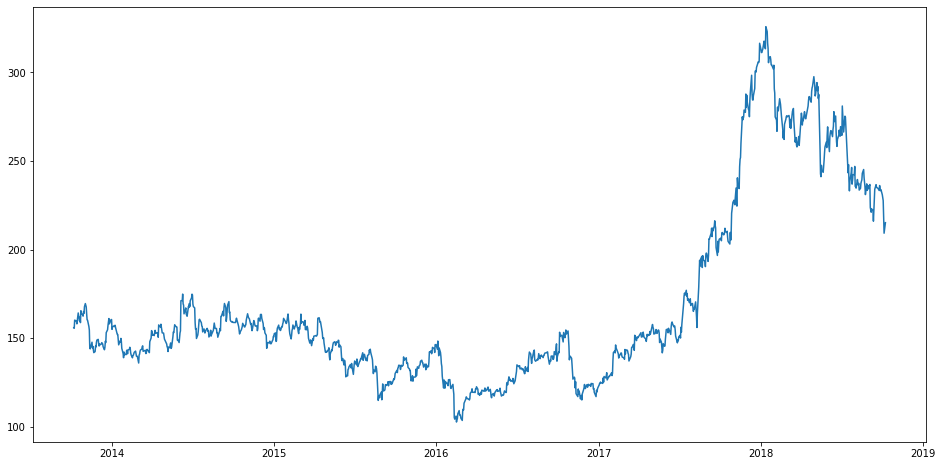

In [116]:
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price')

I will be using keras to create a LSTM model to do the necessary time series forecasting

Importing necessary Libraries

In [117]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras import backend as K


Sorting it and flitering only closing date

In [118]:
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

In [119]:
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

Splitting the given data into training and testing sets

In [120]:
dataset = new_data.values

train = dataset[0:987,:]
valid = dataset[987:,:]

Normalizing the data to trainf the data

In [121]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

Buuilding the LSTM Model from keras

In [122]:
from keras.models import Model, Sequential
from keras import backend as K
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)
model.save('/tmp/model')

927/927 - 23s - loss: 0.0010


INFO:tensorflow:Assets written to: /tmp/model/assets


INFO:tensorflow:Assets written to: /tmp/model/assets


Formating the inputs and training the model based on the data

In [124]:
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

Since the model is trained without us knowing what happens inside and just using inputs , abstraction is accomplished

In [125]:
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
type(closing_price)

numpy.ndarray

Finding the root mean square error of the model

In [126]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

23.13805394447673

PLotting the results obtained

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


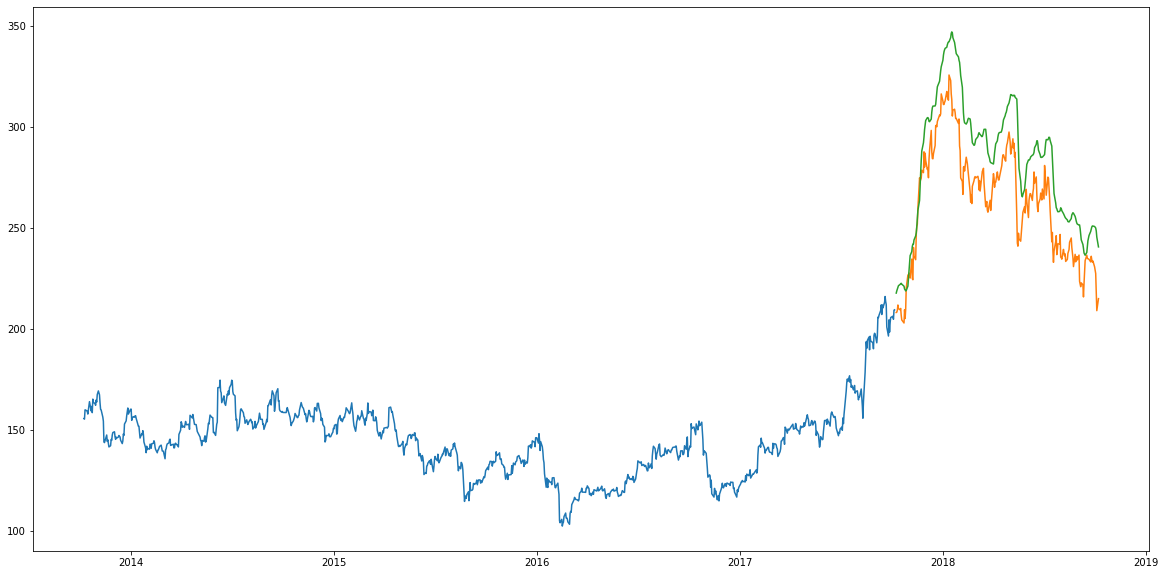

In [136]:
train = new_data[:987]
valid = new_data[987:]
akash = new_data[987:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
 

**For Finding upper bound and Lower Bound**


For this we have taken the predicted prices and used the formula to calculate is 

^y
T
+
h
|
T
±
1.64
^
σ
h

1.64 corresponds to 90%


In [194]:

lowerlimittemp = closing_price - np.std(closing_price)*1.64
valid['lower_lim'] = lowerlimittemp;
upperlimittemp = closing_price + np.std(closing_price)*1.64
valid['upper_lim'] = upperlimittemp



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


**Final output for the dataset we have taken with confidence bounds**

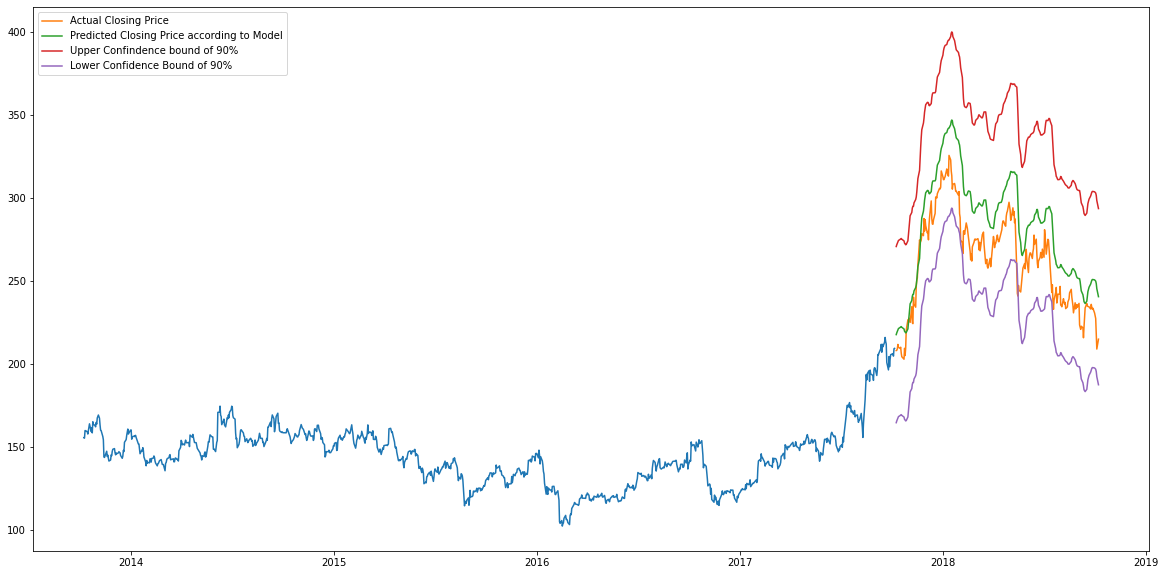

In [195]:
plt.plot(train['Close'])
plt.plot(valid['Close'],label='Actual Closing Price')
plt.plot(valid['Predictions'],label ='Predicted Closing Price according to Model' )
plt.plot(valid['upper_lim'],label = 'Upper Confindence bound of 90%') 
plt.plot(valid['lower_lim'],label = 'Lower Confidence Bound of 90%')           
plt.legend()
